# Mind the Gap: Metadata Completion for Wellcome Catalogue
```Bash
author Louis Larcher, Arthur Taieb and Cassio Manuguera
```

**Abstract**  
The Wellcome Collection is a vast and culturally diverse set of materials, ranging from medical and ethnographic objects, historical manuscripts, books and journals spanning dozens of cultures and over 50 languages. Its materials range from everyday items to rare documents and artworks, making it a rich resource for understanding health, culture and the human experience across time.

Yet despite the breadth and value of these holdings, many items suffer from missing or incomplete metadata—such as unknown dates, origins or creators—which limits how effectively they can be catalogued, searched or interpreted. Our project aims to address this challenge by developing machine-learning methods to predict or approximate these missing fields using available textual descriptions and, when possible, images. By providing archivists with reliable, data-driven estimates, we seek to help enrich the Wellcome Collection’s records and improve access to its diverse cultural heritage.



In [68]:
from pathlib import Path
import gzip
import json
import pandas as pd
from tqdm.auto import tqdm


def load_wellcome_data_kaggle(n_samples=10_000):
    path = Path("/kaggle/input/welcome-dataset/works.json")

    print(f"Loading {n_samples:,} samples from {path}")

    works = []

    # Detect gz or plain json correctly
    open_fn = gzip.open if path.suffix == ".gz" else open

    with open_fn(path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(tqdm(f, total=n_samples)):
            if i >= n_samples:
                break
            try:
                work = json.loads(line)
                works.append(extract_all_fields(work))
            except json.JSONDecodeError:
                continue

    df = pd.DataFrame(works)
    print(f"✓ Loaded {len(df):,} rows")
    return df


In [64]:
import pandas as pd
from IPython.display import display

def print_one_random_record(df):
    print("\nA random record from the dataframe:\n")
    # show full content of a random picked row without truncation
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)

    display(df.sample(1).T)


In [65]:
import pandas as pd

def format_row(row, exclude):
    parts = []
    for col in row.index:
        if col not in exclude:
            col_upper = col.upper()
            value = row[col]
            # Remplacer NaN par chaîne vide
            if pd.isna(value):
                value = ""
            parts.append(f"[{col_upper}: {{{value}}}]")
    return " ".join(parts)


In [66]:
# IMPORT ALL THE NEEDED FILES AND LIBRARIES
import sys
#sys.path.insert(1, '/kaggle/input/requirements-txt/requirements.txt')
#!pip install -r /kaggle/input/my-requirements/requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
from pathlib import Path
from IPython.display import display, HTML
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import pipeline,BertTokenizer, TrainingArguments, Trainer, BertForSequenceClassification


## Exploratory Data Analysis 

To start this project we will first load the data and perform some basic analysis 
to understand the data we are working with.

In [70]:
raw_dataset = load_wellcome_data_kaggle(
    n_samples=10_000,
)
raw_dataset.head()

Loading 10,000 samples from /kaggle/input/welcome-dataset/works.json


  0%|          | 0/10000 [00:00<?, ?it/s]

✓ Loaded 10,000 rows


,id,title,alternativeTitles,workType,workType_id,description,physicalDescription,lettering,edition,production_date,production_date_from,production_date_to,production_places,production_agents,production_function,contributors,contributor_roles,contributor_ids,subjects,subject_ids,genres,genre_ids,languages,language_ids,identifiers,isbn,issn,sierra_system_number,wellcome_library_number,notes,note_types,thumbnail_url,has_digitized_items,items_count,availability_status,partOf_title,partOf_id,parts_count,precededBy_title,precededBy_id,succeededBy_title,succeededBy_id,holdings_count,referenceNumber,images_count
0,fn7skf7m,Prem Sarin / R. Doshi.,None,Books,a,None,page 575 : color portrait,None,None,2000,None,None,England,None,None,"Doshi, R.",Unknown,kgw3qhps,"Sarin, Prem, 1920-2000.",bm8ntt8m,Obituaries,None,English,eng,sierra-system-number:b15255931; sierra-identifier:1525593,None,None,b15255931,None,Obituary | Died Mar. 23 2000. GP,Notes; Biographical note,None,False,1,None,BMJ (General practice ed.).,None,0,None,None,None,None,0,None,0
1,yks9nc8c,"White paper on science and technology, 1999 : new developments in science and technology policy : responding to national and societal needs / edited by Science and Technology Agency, Japanese Government.",None,Books,a,None,467 pages ; 30 cm,None,None,2000,None,None,Tokyo,Japan Science and Technology Corporation,None,Science and Technology Agency; Japan Science and Technology Corporation,Unknown; Unknown,tv5njrmv; v6fmdqw5,Science; Technology; Public Policy; Japan,np8ek677; jr7tc6ky; aq7ns7he; vcqcqced,None,None,English,eng,sierra-system-number:b14980381; sierra-identifier:1498038; isbn:4888902658,4888902658,None,b14980381,None,None,None,None,False,1,None,None,None,0,None,None,None,None,0,None,0
2,qhp7p4ke,Physic and physicians as depicted in Plato / [William Osler].,None,Books,a,None,pages 45-71,None,None,1946,None,None,"No place, unknown, or undetermined",None,None,William Osler,Unknown,rj2c3jap,None,None,None,None,None,None,sierra-system-number:b13772272; sierra-identifier:1377227,None,None,b13772272,None,"""Johns Hopkins Hospital Historical Club, 1893""",Notes,None,False,1,None,"Aequanimitas : with other addresses to medical students, nurses and practitioners of medicine",None,0,None,None,None,None,0,None,0
3,zk9zvhxq,"The malformations, diseases and injuries of the fingers and toes and their surgical treatment / by Thomas Annandale.",None,Books,a,None,"xvi, 292 pages, 10 plates : illustrations ; 23 cm",None,None,1865,None,None,Edinburgh; (Edinburgh,Edmonston & Douglas; Thomas Constable),Manufacture,Thomas Annandale,Unknown,w6p57w3w,Fingers; Toes; Fingers; Toes,fpah3zvv; ptz4vetv; rs24v58b; f895mmdx,None,None,English,eng,sierra-system-number:b11191132; sierra-identifier:1119113; sierra-system-number:b33768705; sierra-identifier:3376870,None,None,b33768705,None,Copy 1 Note: Author's unsigned dedication on t.p.,Notes,None,False,1,Open,None,None,0,None,None,None,None,0,None,0
4,h994efaq,Berliner Alchemisten und Chemiker : Rückblick auf die Entwicklung der chemischen Wissenschaft in der Mark / [A.W. Hofmann].,None,Books,a,None,80 pages ; 21 cm,None,None,[1965],None,None,Wiesbaden,M. Sändig,None,August Wilhelm von Hofmann,Unknown,krhsj9ht,Alchemy; Chemistry; Berlin,r5h97wz2; uct3b5k9; dngbqs4s,None,None,German,ger,sierra-system-number:b13484886; sierra-identifier:1348488,None,None,b13484886,None,"""Rede, gehalten zur Feier des Stiftungstages der militärärztlichen Bildungsanstalten am 2. August, 1882"" | Reprint of 1882 edition",Notes,None,False,1,None,None,None,0,None,None,None,None,0,None,0


We can see that a lot of fields are quite empty thus we will juste get rid of them and work with less fields. Arbitrarly we choose to take out the fields that have more than 80% of missing values, the only exception is the `description` field because it gives a lot of information when present.

In [71]:
threshold = 0.80
missing_pct = raw_dataset.isnull().sum() / len(raw_dataset)

# columns under the threshold
cols_to_keep = missing_pct[missing_pct <= threshold].index.tolist()

# we get rid of every column with more than treshold% of NaNs except description because of its relevance
if "description" in raw_dataset.columns and "description" not in cols_to_keep:
    cols_to_keep.append("description")

filtered = raw_dataset[cols_to_keep]

In [72]:
cols = filtered.columns.to_list()
print(f'We now have {len(cols)} columns:')
print(*cols,sep='\n')

We now have 30 columns:
id
title
workType
workType_id
description
physicalDescription
production_date
production_places
production_agents
contributors
contributor_roles
contributor_ids
subjects
subject_ids
genres
languages
language_ids
identifiers
sierra_system_number
notes
note_types
has_digitized_items
items_count
availability_status
partOf_title
partOf_id
parts_count
holdings_count
referenceNumber
images_count



Our filtered dataset has: 30 columns and 10000 rows.


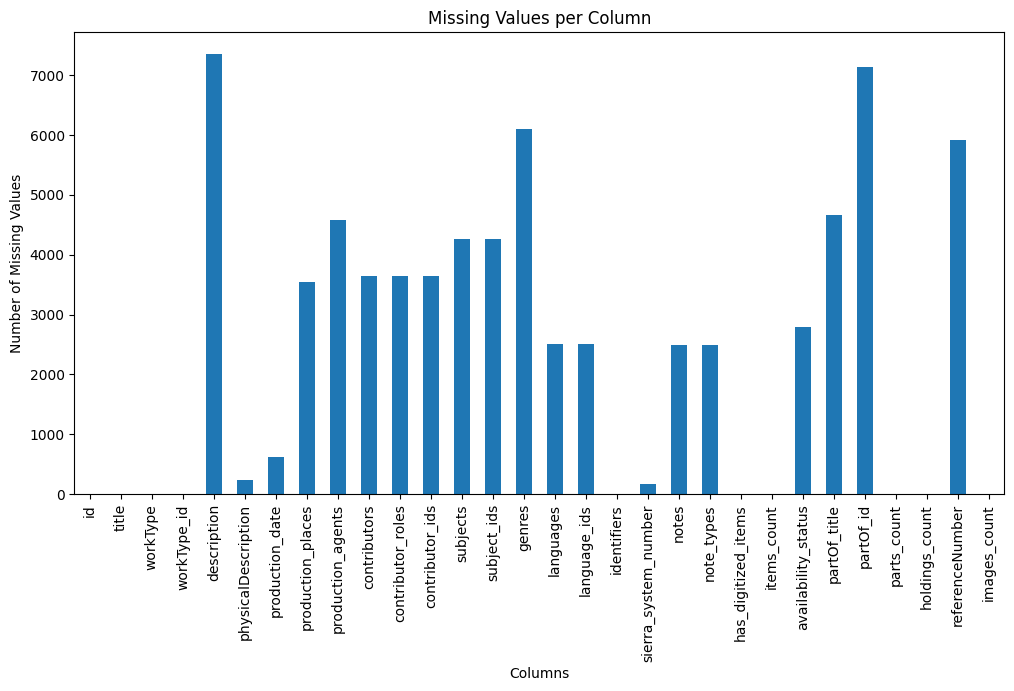


A random record from the dataframe:



,7834
id,wrbd48e4
title,"The inquirer. No. VIII, On dentition, considered as a cause of disease in children."
workType,Books
workType_id,a
description,None
physicalDescription,pages 62-67
production_date,1807
production_places,"No place, unknown, or undetermined"
production_agents,None
contributors,James Wardrop


In [74]:
# shape of the dataset
print(f"\nOur filtered dataset has: {filtered.shape[1]} columns and {filtered.shape[0]} rows.")

# how many missing values per column
missing_values = filtered.isnull().sum()

plt.figure(figsize=(12,6))
plt.title("Missing Values per Column")
missing_values.plot(kind='bar')
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.show();

print_one_random_record(filtered)

We have now a dataframe more or less filtered but we still have a lot of columns that make no sense to use for our task, for example the _identifiers_. We will have to do some more __feature selection__.

In [75]:
# Remove non-predictable columns and with no corelation to the target
columns_to_remove = [
    # System IDs - just internal database identifiers, not predictable
    'id', 'workType_id', 'contributor_ids', 'subject_ids', 'language_ids', 
    'identifiers', 'sierra_system_number',
    
    # Counts - database metadata, not intrinsic properties of the work
    'items_count', 'parts_count', 'holdings_count', 'images_count',
    
    # Operational data - library-specific, not about the work itself
    'has_digitized_items', 'availability_status',
    
    # Less useful duplicates - keep the main version, remove auxiliary
    'note_types'  # Keep 'notes', remove the types since notes contain more info
]
necessary_df = filtered.copy().drop(columns=columns_to_remove);

# Display percentage of missing values per column with a custom styled table
null_pct = necessary_df.isnull().mean().sort_values(ascending=False) * 100
train_null = pd.DataFrame({
    "Column": null_pct.index,
    "% Null": [f"{v:.2f}%" for v in null_pct.values]
})

css = """
<style> 
.table-fixed {border-collapse: collapse; width: 70%; max-width: 900px;} 
.table-fixed th, 
.table-fixed td {border: 1px solid #ddd; padding: 6px 10px; text-align: left;} 
.table-fixed th {background:#808080; font-weight:600;} 
</style>
"""
print('We finally have only those columns left')
display(HTML(css + train_null.to_html(index=False, classes="table-fixed", escape=False)))

We finally have only those columns left


Column,% Null
description,73.47%
partOf_id,71.26%
genres,60.99%
referenceNumber,59.18%
partOf_title,46.60%
production_agents,45.84%
subjects,42.63%
contributors,36.37%
contributor_roles,36.37%
production_places,35.38%


In [76]:
print_one_random_record(necessary_df)


A random record from the dataframe:



,3568
title,Studies in heterogenesis / by H. Charlton Bastian ... with eight hundred and fifteen illustrations from photomicrographs.
workType,Books
description,None
physicalDescription,"ix, 354, xxxvii pages, xix plate (16 folded) ; 27 cm"
production_date,1903
production_places,London ;; Oxford [etc.]
production_agents,Williams and Norgate
contributors,Henry Charlton Bastian
contributor_roles,Unknown
subjects,Reproduction; Life - Origin - history


__Our dataset only contains columns that interest us.__ 

# Preprocessing
We now have to __preprocess__ the data. The goal is to predict missing values in the dataset using the other fields as input so we will not have to fill NaNs. But we still have to deal with classic preprocessings such as categorical variables encoding, text vectorization and normalization.

We do not want to _infect_ our testing dataset with the training one. So we split them before any normalization.

In [77]:
train_test_ratio = 0.8
train = necessary_df.sample(frac = train_test_ratio, random_state= 42)
test = necessary_df.drop(train.index)
print(f"We decide to use {train_test_ratio*100}% of the data for the training.\n"
      f"Therefore we have a training sample of size {train.shape} and the test one of size {test.shape}")

We decide to use 80.0% of the data for the training.
Therefore we have a training sample of size (8000, 16) and the test one of size (2000, 16)


In [78]:
cumsum = train['production_places'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.80).sum()} of the values to span 80% of all the production_places inside the dataset")
cumsum = train['languages'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.95).sum()} of the values to span 95% of all the languages inside the dataset")
cumsum = train['workType'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.95).sum()} of the values to span 95% of all the workType inside the dataset")


We need the top 383 of the values to span 80% of all the production_places inside the dataset
We need the top 17 of the values to span 95% of all the languages inside the dataset
We need the top 3 of the values to span 95% of all the workType inside the dataset


## Data Preprocessing Strategy

Our preprocessing pipeline is intentionally **minimal** - we leverage BERT's native ability to handle raw text and categorical data without explicit feature engineering.

### Target Variable

- **`production_date`**: Extract numeric year values from production_date strings via regex. This becomes our regression target.

### Minimal Preprocessing Rationale

Rather than traditional preprocessing (one-hot encoding, TF-IDF vectorization), we feed raw data directly to BERT for several reasons:

**Why not one-hot encode categorical features?**
- `workType` has only 16 unique values → trivial to one-hot encode
- But BERT embeddings capture semantic relationships better than binary vectors
- Example: "Book" and "Journal" are semantically closer than their one-hot representations suggest
- BERT learns distributed representations that preserve categorical meaning

**Why not TF-IDF for text?**
- TF-IDF treats words independently; BERT captures contextual relationships
- TF-IDF loses temporal signals (e.g., "1928" is just another term); BERT recognizes date expressions
- BERT handles variable-length sequences naturally without dimensionality reduction

**Direct comparison:** We compare TF-IDF + simple regressors against BERT embeddings + simple regressors to quantify improvement.

### Preprocessing Pipeline

1. **Merge Text Features**: Concatenate all text columns (title, description, notes, physicalDescription, partOf_title, production_places, production_agents, subjects, genres, languages, workType, contributors) into single text string with field separators

2. **Format for BERT**: Create input with structure:
```
   [TITLE: {title}] [DESC: {description}] [TYPE: {workType}] [LANG: {languages}] [SUBJ: {subjects}] ...
```
   Field labels help BERT distinguish information types

3. **Target Extraction**: Parse `production_date` → extract year as integer and not string

4. **Final Dataset**: Two columns:
   - `text`: Merged BERT input string
   - `year`: Target variable (numeric)

### Why This Works

BERT's transformer architecture:
- Handles variable text lengths without dimensionality reduction
- Learns categorical embeddings automatically through token representation
- Captures semantic relationships (e.g., "published 1950" → temporal context)
- No manual feature engineering needed

Result: Cleaner pipeline, better feature representations, comparison baseline (TF-IDF) included.

In [79]:
for col in train.columns:
    types = train[col].apply(lambda x: type(x).__name__).unique()
    print(col, "->", types)

title -> ['str']
workType -> ['str']
description -> ['NoneType' 'str']
physicalDescription -> ['str' 'NoneType']
production_date -> ['str' 'NoneType']
production_places -> ['str' 'NoneType']
production_agents -> ['str' 'NoneType']
contributors -> ['str' 'NoneType']
contributor_roles -> ['str' 'NoneType']
subjects -> ['str' 'NoneType']
genres -> ['str' 'NoneType']
languages -> ['str' 'NoneType']
notes -> ['str' 'NoneType']
partOf_title -> ['str' 'NoneType']
partOf_id -> ['NoneType' 'str']
referenceNumber -> ['NoneType' 'str']


We merge all the column of the dataframe to simplify the format for BERT embeding. Only `thumbnail_url` and `production_date` are kept as they already are.

In [80]:
# We keep production_date in a separate column and the thumbnail URL too
columns_to_merge = [c for c in train.columns 
                    if c not in ["production_date", "thumbnail_url"]]

df_for_merge = train[columns_to_merge].copy()

def format_row(row):
    parts = []
    for col in row.index:
        col_upper = col.upper()
        value = row[col]

        if pd.isna(value):
            value = ""

        parts.append(f"[{col_upper}: {{{value}}}]")

    return " ".join(parts)

# Create MERGED in a separate dataframe
merged_train = pd.DataFrame()
merged_train["MERGED"] = df_for_merge.apply(format_row, axis=1)

# Add the two separated columns (from train)
merged_train["production_date"] = pd.to_numeric(
    train["production_date"], errors="coerce"
)

merged_train = merged_train.reset_index(drop = True)
print_one_random_record(merged_train)


A random record from the dataframe:



,420
MERGED,"[TITLE: {A northern diver (Colymbus glacialis) Colour lithograph, ca. 1875.}] [WORKTYPE: {Pictures}] [DESCRIPTION: {}] [PHYSICALDESCRIPTION: {1 print : chromolithograph ; sheet 25.5 x 18.1 cm}] [PRODUCTION_PLACES: {No place, unknown, or undetermined}] [PRODUCTION_AGENTS: {}] [CONTRIBUTORS: {}] [CONTRIBUTOR_ROLES: {}] [SUBJECTS: {Water birds; Divers (Birds)}] [GENRES: {Chromolithographs}] [LANGUAGES: {English; Latin}] [NOTES: {Wellcome Collection 42899i}] [PARTOF_TITLE: {}] [PARTOF_ID: {}] [REFERENCENUMBER: {42899i}]"
production_date,1875.0


## BERT

In [85]:
from datasets import Dataset
from transformers import (
    BertTokenizer, 
    DistilBertConfig, 
    DistilBertForSequenceClassification,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
import shutil
import torch

def prepare_data(data):
    """Clean data: remove NaN and outliers"""
    clean = data.dropna(subset=['production_date']).copy()
    clean['production_date'] = pd.to_numeric(clean['production_date'], errors='coerce')
    clean = clean.dropna(subset=['production_date'])
    clean = clean[(clean['production_date'] >= 1400) & (clean['production_date'] <= 2030)]
    return clean


def compute_metrics(eval_pred):
    """Custom metrics for regression"""
    predictions, labels = eval_pred
    predictions = predictions.flatten()
    
    mae = np.mean(np.abs(predictions - labels))
    median_ae = np.median(np.abs(predictions - labels))
    rmse = np.sqrt(np.mean((predictions - labels) ** 2))
    
    return {
        'mae': mae,
        'median_ae': median_ae,
        'rmse': rmse,
    }


def train_model(train_data, model_save_path="./saved_model", fast_mode=False):
    """
    Train DistilBERT for year prediction with best practices
    
    Args:
        train_data: DataFrame with 'MERGED' and 'production_date' columns
        model_save_path: Path to save the trained model
        fast_mode: If True, use fast settings for testing (default: False for production)
    """
    
    # ============================================================================
    # 1. DATA PREPARATION
    # ============================================================================
    
    print("="*70)
    print("STEP 1: DATA PREPARATION")
    print("="*70)
    
    print(f"Original size: {len(train_data)}")
    train_data = prepare_data(train_data)
    
    print(f"After cleaning: {len(train_data)}")
    print(f"Year range: {train_data['production_date'].min():.0f} - {train_data['production_date'].max():.0f}")
    print(f"Mean year: {train_data['production_date'].mean():.1f}")
    print(f"Std year: {train_data['production_date'].std():.1f}")
    
    if len(train_data) < 100:
        raise ValueError(f"Not enough training data! Got {len(train_data)}, need at least 100")
    
    # ============================================================================
    # 2. NORMALIZATION (CRITICAL FOR REGRESSION!)
    # ============================================================================
    
    print("\n" + "="*70)
    print("STEP 2: LABEL NORMALIZATION")
    print("="*70)
    
    # Normalize years to [0, 1] range for better training
    year_min = train_data['production_date'].min()
    year_max = train_data['production_date'].max()
    year_range = year_max - year_min
    
    train_data['normalized_year'] = (train_data['production_date'] - year_min) / year_range
    
    print(f"Normalized range: [{train_data['normalized_year'].min():.3f}, {train_data['normalized_year'].max():.3f}]")
    
    # Save normalization params for later
    norm_params = {
        'year_min': float(year_min),
        'year_max': float(year_max),
        'year_range': float(year_range)
    }
    
    # ============================================================================
    # 3. TRAIN/VAL SPLIT
    # ============================================================================
    
    print("\n" + "="*70)
    print("STEP 3: TRAIN/VALIDATION SPLIT")
    print("="*70)
    
    train_pd, val_pd = train_test_split(
        train_data, 
        test_size=0.15,  # 15% for validation
        random_state=42,
        stratify=pd.cut(train_data['production_date'], bins=10, labels=False)  # Stratify by year bins
    )
    
    print(f"Train size: {len(train_pd)} ({len(train_pd)/len(train_data)*100:.1f}%)")
    print(f"Val size: {len(val_pd)} ({len(val_pd)/len(train_data)*100:.1f}%)")
    
    # Convert to HuggingFace datasets
    train_hf = Dataset.from_pandas(train_pd.reset_index(drop=True))
    val_hf = Dataset.from_pandas(val_pd.reset_index(drop=True))
    
    # ============================================================================
    # 4. TOKENIZATION
    # ============================================================================
    
    print("\n" + "="*70)
    print("STEP 4: TOKENIZATION")
    print("="*70)
    
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    # Check average text length to optimize max_length
    avg_length = train_data['MERGED'].str.len().mean()
    print(f"Average text length: {avg_length:.0f} characters")
    
    # Set max_length based on your data (use longer for production)
    max_length = 256 if not fast_mode else 128
    
    def tokenize(batch):
        return tokenizer(
            batch["MERGED"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )
    
    print(f"Max sequence length: {max_length} tokens")
    print("Tokenizing datasets...")
    
    train_hf = train_hf.map(tokenize, batched=True, batch_size=1000)
    val_hf = val_hf.map(tokenize, batched=True, batch_size=1000)
    
    # Prepare for training (use normalized labels)
    train_hf = train_hf.rename_column("normalized_year", "labels")
    val_hf = val_hf.rename_column("normalized_year", "labels")
    train_hf.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    val_hf.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    
    # ============================================================================
    # 5. MODEL INITIALIZATION
    # ============================================================================
    
    print("\n" + "="*70)
    print("STEP 5: MODEL INITIALIZATION")
    print("="*70)
    
    config = DistilBertConfig.from_pretrained(
        "distilbert-base-uncased",
        num_labels=1,
        problem_type="regression"  # Important!
    )
    
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        config=config,
        ignore_mismatched_sizes=True
    )
    
    print("✓ Model initialized")
    
    # ============================================================================
    # 6. TRAINING CONFIGURATION
    # ============================================================================
    
    print("\n" + "="*70)
    print("STEP 6: TRAINING CONFIGURATION")
    print("="*70)
    
    if fast_mode:
        print("⚡ FAST MODE - For quick testing")
        training_args = TrainingArguments(
            output_dir="./model_output",
            num_train_epochs=2,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=64,
            learning_rate=5e-5,
            warmup_ratio=0.1,
            weight_decay=0.01,
            eval_strategy="steps",
            eval_steps=100,
            save_strategy="steps",
            save_steps=100,
            logging_steps=50,
            load_best_model_at_end=True,
            metric_for_best_model="mae",
            greater_is_better=False,
            save_total_limit=2,
            fp16=torch.cuda.is_available(),
            dataloader_num_workers=0,
            report_to="none",
        )
    else:
        print("PRODUCTION MODE - Best quality")
        training_args = TrainingArguments(
            output_dir="./model_output",
            
            # Training duration
            num_train_epochs=2,  # 3-5 epochs usually best
            
            # Batch sizes (adjust based on your GPU memory)
            per_device_train_batch_size=16,  # Smaller = more stable, larger = faster
            per_device_eval_batch_size=32,
            gradient_accumulation_steps=2,  # Effective batch size = 16 * 2 = 32
            
            # Learning rate (most important hyperparameter!)
            learning_rate=2e-5,  # 2e-5 to 5e-5 usually works best for BERT
            warmup_ratio=0.1,  # Warm up for 10% of training
            
            # Regularization
            weight_decay=0.01,  # Prevents overfitting
            
            # Evaluation and saving
            eval_strategy="epoch",  # Evaluate after each epoch
            save_strategy="epoch",
            logging_steps=100,
            load_best_model_at_end=True,
            metric_for_best_model="mae",
            greater_is_better=False,
            save_total_limit=3,  # Keep only best 3 checkpoints
            
            # Performance
            fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
            dataloader_num_workers=4 if torch.cuda.is_available() else 0,
            
            # Misc
            seed=42,
            report_to="none",  # Change to "wandb" if you want to track experiments
        )
    
    # ============================================================================
    # 7. TRAINER SETUP
    # ============================================================================
    
    print("\n" + "="*70)
    print("STEP 7: INITIALIZING TRAINER")
    print("="*70)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_hf,
        eval_dataset=val_hf,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=3  # Stop if no improvement for 3 evaluations
            )
        ] if not fast_mode else [],
    )
    
    # ============================================================================
    # 8. TRAINING
    # ============================================================================
    
    print("\n" + "="*70)
    print("STEP 8: TRAINING")
    print("="*70)
    print("This may take a while...")
    print("GPU available:" if torch.cuda.is_available() else "Running on CPU (will be slower)")
    print("="*70 + "\n")
    
    trainer.train()
    
    print("\n" + "="*70)
    print("TRAINING COMPLETED!")
    print("="*70)
    
    # ============================================================================
    # 9. EVALUATION
    # ============================================================================
    
    print("\n" + "="*70)
    print("STEP 9: FINAL EVALUATION")
    print("="*70)
    
    eval_results = trainer.evaluate()
    print("\nValidation Metrics:")
    for key, value in eval_results.items():
        if key.startswith('eval_'):
            # Denormalize MAE back to years
            if 'mae' in key or 'median' in key or 'rmse' in key:
                value_in_years = value * year_range
                print(f"  {key}: {value:.4f} (normalized) = {value_in_years:.2f} years")
            else:
                print(f"  {key}: {value:.4f}")
    
    # ============================================================================
    # 10. SAVE MODEL
    # ============================================================================
    
    print("\n" + "="*70)
    print("STEP 10: SAVING MODEL")
    print("="*70)
    
    trainer.save_model(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    
    # Save normalization parameters
    import json
    with open(os.path.join(model_save_path, "norm_params.json"), "w") as f:
        json.dump(norm_params, f)
    
    print(f"✓ Model saved to: {model_save_path}")
    print(f"✓ Tokenizer saved")
    print(f"✓ Normalization params saved")
    
    return model_save_path, norm_params


def load_and_predict(test_data, model_path="./saved_model"):
    """
    Load trained model and make predictions
    """
    import json
    
    print("\n" + "="*70)
    print("LOADING MODEL AND PREDICTING")
    print("="*70)
    
    # Load normalization params
    with open(os.path.join(model_path, "norm_params.json"), "r") as f:
        norm_params = json.load(f)
    
    year_min = norm_params['year_min']
    year_max = norm_params['year_max']
    year_range = norm_params['year_range']
    
    print(f"Normalization params: min={year_min:.0f}, max={year_max:.0f}, range={year_range:.0f}")
    
    # Load model and tokenizer
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    
    print("✓ Model and tokenizer loaded")
    
    # Tokenize
    def tokenize(batch):
        return tokenizer(
            batch["MERGED"],
            truncation=True,
            padding="max_length",
            max_length=256  # Match training
        )
    
    test_pd = test_data.copy().reset_index(drop=True)
    test_hf = Dataset.from_pandas(test_pd)
    test_hf = test_hf.map(tokenize, batched=True, batch_size=1000)
    test_hf.set_format("torch", columns=["input_ids", "attention_mask"])
    
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./tmp_predict",
            per_device_eval_batch_size=32,
            dataloader_num_workers=0,  # 🔴 CRITICAL on Kaggle
            report_to="none",
        ),
    )

    print("Making predictions...")
    preds = trainer.predict(test_hf).predictions
    # Denormalize predictions back to years
    test_pd["predicted_year"] = preds * year_range + year_min
    
    print("✓ Predictions complete")
    
    return test_pd


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    
    model_path = "./saved_model"
    
    # Clean start
    if os.path.exists(model_path):
        print("Removing old model...")
        shutil.rmtree(model_path)
    
    # Choose training mode
    FAST_MODE = False  # Set to True for quick testing, False for best results
    
    print("\n" + "="*70)
    print("TRAINING BERT FOR YEAR PREDICTION")
    print("="*70)
    print(f"Mode: {'FAST (testing)' if FAST_MODE else 'PRODUCTION (best quality)'}")
    print("="*70 + "\n")
    
    # Train
    model_path, norm_params = train_model(merged_train, model_path, fast_mode=FAST_MODE)
    
    # Prepare test data with MERGED column
    print("\n" + "="*70)
    print("PREPARING TEST DATA")
    print("="*70)
    
    columns_to_merge = [c for c in test.columns 
                        if c not in ["production_date", "thumbnail_url"]]
    df_for_merge = test[columns_to_merge].copy()
    
    def format_row(row):
        parts = []
        for col in row.index:
            col_upper = col.upper()
            value = row[col]
            if pd.isna(value):
                value = ""
            parts.append(f"[{col_upper}: {{{value}}}]")
        return " ".join(parts)
    
    merged_test = pd.DataFrame()
    merged_test["MERGED"] = df_for_merge.apply(format_row, axis=1)
    if "production_date" in test.columns:
        merged_test["production_date"] = pd.to_numeric(test["production_date"], errors="coerce")
    merged_test = merged_test.reset_index(drop=True)
    
    # Predict
    test_with_predictions = load_and_predict(merged_test, model_path)
    
    # Display results
    print("\n" + "="*70)
    print("FINAL RESULTS")
    print("="*70)
    
    print("\nSample predictions:")
    display_cols = ["predicted_year"]
    if "production_date" in test_with_predictions.columns:
        display_cols.insert(0, "production_date")
    
    print(test_with_predictions[display_cols].head(10))
    
    # Calculate metrics
    if "production_date" in test_with_predictions.columns:
        valid = test_with_predictions.dropna(subset=['production_date'])
        valid = valid[(valid['production_date'] >= 1400) & (valid['production_date'] <= 2030)]
        
        if len(valid) > 0:
            valid["error"] = abs(valid["production_date"] - valid["predicted_year"])
            
            print(f"\n{'='*70}")
            print("TEST SET PERFORMANCE")
            print("="*70)
            print(f"Valid samples: {len(valid)}/{len(test_with_predictions)}")
            print(f"MAE: {valid['error'].mean():.2f} years")
            print(f"Median Error: {valid['error'].median():.2f} years")
            print(f"RMSE: {np.sqrt((valid['error']**2).mean()):.2f} years")
            print(f"Max Error: {valid['error'].max():.2f} years")
            print(f"Min Error: {valid['error'].min():.2f} years")
            
            # Error percentiles
            print(f"\nError Percentiles:")
            print(f"  25th percentile: {valid['error'].quantile(0.25):.2f} years")
            print(f"  50th percentile: {valid['error'].quantile(0.50):.2f} years")
            print(f"  75th percentile: {valid['error'].quantile(0.75):.2f} years")
            print(f"  90th percentile: {valid['error'].quantile(0.90):.2f} years")
    
    print("="*70)
    print("✓ TRAINING AND EVALUATION COMPLETE!")
    print("="*70)

Removing old model...

TRAINING BERT FOR YEAR PREDICTION
Mode: PRODUCTION (best quality)

STEP 1: DATA PREPARATION
Original size: 8000
After cleaning: 3901
Year range: 1472 - 2023
Mean year: 1903.1
Std year: 131.2

STEP 2: LABEL NORMALIZATION
Normalized range: [0.000, 1.000]

STEP 3: TRAIN/VALIDATION SPLIT
Train size: 3315 (85.0%)
Val size: 586 (15.0%)

STEP 4: TOKENIZATION
Average text length: 722 characters
Max sequence length: 256 tokens
Tokenizing datasets...


Map:   0%|          | 0/3315 [00:00<?, ? examples/s]

Map:   0%|          | 0/586 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STEP 5: MODEL INITIALIZATION
✓ Model initialized

STEP 6: TRAINING CONFIGURATION
PRODUCTION MODE - Best quality

STEP 7: INITIALIZING TRAINER

STEP 8: TRAINING
This may take a while...
GPU available:



/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mae,Median Ae,Rmse
1,No log,0.015251,0.086709,0.058625,0.123493
2,0.085400,0.008356,0.064662,0.045084,0.091409


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



TRAINING COMPLETED!

STEP 9: FINAL EVALUATION


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Validation Metrics:
  eval_loss: 0.0084
  eval_mae: 0.0647 (normalized) = 35.63 years
  eval_median_ae: 0.0451 (normalized) = 24.84 years
  eval_rmse: 0.0914 (normalized) = 50.37 years
  eval_runtime: 2.9330
  eval_samples_per_second: 199.7960
  eval_steps_per_second: 3.4090

STEP 10: SAVING MODEL
✓ Model saved to: ./saved_model
✓ Tokenizer saved
✓ Normalization params saved

PREPARING TEST DATA

LOADING MODEL AND PREDICTING
Normalization params: min=1472, max=2023, range=551
✓ Model and tokenizer loaded


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Making predictions...


✓ Predictions complete

FINAL RESULTS

Sample predictions:
   production_date  predicted_year
0           2000.0     2041.201416
1              NaN     1959.321777
2           2014.0     1904.825439
3              NaN     1962.900391
4           1898.0     1905.741089
5           1951.0     1958.006226
6              NaN     1972.712402
7              NaN     1954.654907
8           1981.0     1987.433105
9              NaN     1962.095215

TEST SET PERFORMANCE
Valid samples: 1005/2000
MAE: 35.89 years
Median Error: 26.48 years
RMSE: 51.51 years
Max Error: 317.06 years
Min Error: 0.00 years

Error Percentiles:
  25th percentile: 11.05 years
  50th percentile: 26.48 years
  75th percentile: 46.62 years
  90th percentile: 81.41 years
✓ TRAINING AND EVALUATION COMPLETE!
